In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_recall_curve, precision_score, average_precision_score
from sklearn.preprocessing import label_binarize
import itertools
import matplotlib.pyplot as plt
import os, time
from PIL import Image, ImageOps
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(device)

cuda:0


In [2]:
# Functions and default variables
data_path = "../../data/image_classification/input/"

# Function for plotting images in batch
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 4, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Function for plotting (3,244,244) shaped images
def plot_images_tensor(images_arr):
    plt.imshow(images_arr.permute(1,2,0))
    plt.axis('off') # axis tick과 눈금을 안 그림
    plt.show()
    plt.clf()

# Function for creating & plotting confusion metrics
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_precision_recall_curve_multiclass(y_test, y_proba, class_names):
    n_classes = len(class_names)
    # 레이블 이진화
    y_test_bin = label_binarize(y_test, classes=range(n_classes))

    # 각 클래스에 대한 precision-recall curve 계산
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], y_proba[:, i])

    # 마이크로 평균 precision-recall curve 계산
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_proba.ravel())
    average_precision["micro"] = average_precision_score(y_test_bin, y_proba, average="micro")

    # 그래프 그리기
    plt.figure(figsize=(10, 8))
    
    # 각 클래스에 대한 PR curve
    for i,class_name in enumerate(class_names):
        plt.plot(recall[i], precision[i], lw=2, 
                 label=f'Class {class_name} (AP = {average_precision[i]:0.2f})')

    # 마이크로 평균 PR curve
    plt.plot(recall["micro"], precision["micro"], 
             label=f'Micro-average (AP = {average_precision["micro"]:0.2f})',
             color='navy', linestyle=':', linewidth=4)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (Multi-class)")
    plt.legend(loc="best")

아래 코드는 직접 image augmentation을 진행할 때 실행하면 된다.
<s>현재 데이터셋은 image augmentation이 완료된 데이터이다.</s>

In [3]:
# '''
# Data 폴더에서 class별 데이터셋을 전부 불러온다.
# 1. 모두 랜덤하게 200개씩 추출한다.
# 2. 클래스별로 16:3:1 로 train:val:test 비율을 맞춰 랜덤하게 분할한다.
# 3. DataLoader로 만든다.
# '''
start_time = time.time()

class ResizeWithPadding(object):
    def __init__(self, size=(244,244), bg_color=(255,255,255), fill=0):
        self.size = size
        self.bg_color = bg_color
        self.fill = fill

    def __call__(self, image):
        original_ratio = image.width / image.height
        output_ratio = self.size[0] / self.size[1]
        # Determine the new size that fits within the output size while maintaining the aspect ratio
        if original_ratio > output_ratio:
            # Fit to width
            new_width = self.size[0]
            new_height = int(new_width / original_ratio)
        else:
            # Fit to height
            new_height = self.size[1]
            new_width = int(new_height * original_ratio)
        
        # Resize the image
        resized_image = image.resize((new_width, new_height), Image.LANCZOS)

        # Create a new image with the desired size and background color
        new_image = Image.new("RGB", self.size, self.bg_color)
        
        # Paste the resized image onto the center of the new image
        paste_position = ((self.size[0] - new_width) // 2, (self.size[1] - new_height) // 2)
        new_image.paste(resized_image, paste_position)
    
        return new_image

image_datasets = datasets.ImageFolder(data_path, transform=transforms.Compose([
    ResizeWithPadding(size=(244,244)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

class Cutout(object):
    '''
    https://github.com/uoguelph-mlrg/Cutout/blob/master/util/cutout.py 참고
    '''
    def __init__(self, device, n_holes=2, crop_size=20):
        self.crop_size = crop_size
        self.n_holes = n_holes
        self.device = device

    def __call__(self, image):
        width, height = image.size(1), image.size(2)
        mask = np.ones((height, width), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(height)
            x = np.random.randint(width)

            y1 = np.clip(y - self.crop_size // 2, 0, height)
            y2 = np.clip(y + self.crop_size // 2, 0, height)
            x1 = np.clip(x - self.crop_size // 2, 0, width)
            x2 = np.clip(x + self.crop_size // 2, 0, width)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask).to(device)
        mask = mask.expand_as(image)
        image = image * mask

        return image

### Image Augmentation 함수 정의
# augmentation_transform = transforms.Compose([
	# transforms.RandomChoice([ # 아래의 기법들 중 1개만 무작위로 적용
	# 	transforms.RandomApply([
 #            transforms.RandomRotation(degrees=(-45,-45),fill=(255,255,255))
 #        ],p=1.0), #-45도 rotation만
	# 	transforms.RandomApply([
 #            transforms.RandomRotation(degrees=(45,45),fill=(255,255,255))
 #        ],p=1.0), # 45도 ratation만
	# 	transforms.RandomApply(
 #            [transforms.RandomChoice(
 #                [transforms.RandomRotation(degrees=(-45,-45),fill=(255,255,255)), 
 #                 transforms.RandomRotation(degrees=(45,45),fill=(255,255,255))
 #                ]), transforms.RandomGrayscale(p=1.0)
 #            ],p=1.0), # +,-45중 하나의 rotation과 grayscale
	# 	transforms.RandomApply([
 #            transforms.RandomGrayscale(p=1.0)
 #        ],p=1.0), # grayscale 만
 #        transforms.RandomApply([
 #            transforms.RandomInvert(p=1.0) # 반전
 #        ],p=1.0)
	# ]),
#     RandomCropWithPadding(crop_size=()),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

## 무작위로 30%의 샘플을 선택해서 위의 방식으로 증강
# num_samples = len(image_datasets)
# num_augmented = int(0.3*num_samples)
# indices = list(range(num_samples))
# random.shuffle(indices) # augmentation 적용할 index를 무작위로 섞음.
# augmented_indices = indices[:num_augmented]
# non_augmented_indices = indices[num_augmented:]

# 증강 안 할 때 코드
num_samples = len(image_datasets)
combined_dataset = []
for image,label in image_datasets:
    combined_dataset.append((image,label))

# 데이터 Subset 생성
# augmented_dataset = Subset(image_datasets, augmented_indices)
# non_augmented_dataset = Subset(image_datasets, non_augmented_indices)

# Augmentation 적용
# augmented_images = []
# for idx in range(len(augmented_dataset)):
#     image, label = augmented_dataset[idx]
#     # image = augmentation_transform(image)
#     augmented_images.append((image, label))

# Augmentation이 적용되지 않은 데이터셋
# non_augmented_images = []
# for idx in range(len(non_augmented_dataset)):
#     image, label = non_augmented_dataset[idx]
#     non_augmented_images.append((image, label))

# Augmented와 non-augmented 데이터셋 결합
# combined_dataset = augmented_images + non_augmented_images

### 📢데이터셋 분할
# 데이터를 70:20:10 비율로 분할
total_size = len(combined_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

# 무작위로 분할
random.shuffle(combined_dataset)
train_dataset = combined_dataset[:train_size]
val_dataset = combined_dataset[train_size:train_size + val_size]
test_dataset = combined_dataset[train_size + val_size:]

# DataLoader 생성
def collate_fn(batch):
    images, labels = zip(*batch)
    return torch.stack(images, 0), torch.tensor(labels)

dataloaders = {
    'train' : DataLoader(train_dataset, batch_size=20, shuffle=True, 
                          collate_fn=collate_fn), #, num_workers=1) # Windows의 경우 num_workers를 설정하면 error가 날 수 있음.
    'val' : DataLoader(val_dataset, batch_size=20, shuffle=True, 
                          collate_fn=collate_fn), #, num_workers=1)
    'test': DataLoader(test_dataset, batch_size=20, shuffle=False, 
                          collate_fn=collate_fn) #, num_workers=1)
}

end_time = time.time()
print(f"total dataset size : {total_size}\ntrain size : {train_size}, valid size : {val_size}, test size : {test_size}")
print(f"code ends in : {end_time-start_time:0.2f}sec")

total dataset size : 7383
train size : 5168, valid size : 1476, test size : 739
code ends in : 35.55sec


**개선된 데이터셋 버전에선 아래 코드를 사용하지 않는다.**  <br>
<s>현재 데이터셋은 이미지 전처리, 증강이 완료되었으므로 바로 불러와서 fine-tuning을 실행하면 된다.
Roboflow를 통해 아래와 같은 작업을 수행했다.</s>
* <s>Auto-orientation of pixel data (with EXIF-orientation stripping)</s>
* <s>Resize to 244x244 (Fit (white edges))</s>
* <s>chart 데이터만 데이터 개수가 부족하여 image augmentation을 진행했다. → 1043 to 1764</s>
    * <s>Rotation : -45 degree, 45 degree rotation</s>
    * <s>Grayscale : apply to 15% of chart images </s>

In [4]:
# # Dataset Load
# # Defining paths of the train, validation, and test image sources
# train_path = os.sep.join([data_path,'train'])
# val_path = os.sep.join([data_path,'valid'])
# test_path = os.sep.join([data_path,'test'])

# # Data Transformer
# data_transforms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet 기반 pre-trained 모델 fine-tuning 시 일반적으로 사용하는 이미지 정규화 방법
# ])

# # Datasets
# image_datasets = {
#     'train': datasets.ImageFolder(train_path, data_transforms),
#     'val': datasets.ImageFolder(val_path, data_transforms),
#     'test': datasets.ImageFolder(test_path, data_transforms),
# }

# # DataLoaders
# dataloaders = {
#     'train': DataLoader(image_datasets['train'], batch_size=20, shuffle=True),
#     'val': DataLoader(image_datasets['val'], batch_size=20, shuffle=True),
#     'test': DataLoader(image_datasets['test'], batch_size=20, shuffle=False),
# }

# # 각 에포크의 손실과 정확도를 올바르게 계산하고 기록하기 위해 필요
# train_size = len(image_datasets['train'])
# val_size = len(image_datasets['val'])
# test_size = len(image_datasets['test'])

In [5]:
### Class name check
class_counts = {cls: 0 for cls in range(len(image_datasets.classes))}
class_names = image_datasets.classes
print(class_names)

### Class names check
# class_names = image_datasets['train'].classes
# class_names

['chart', 'diagram', 'none', 'table']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


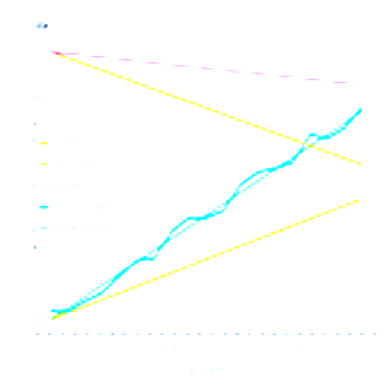

tensor(0)


<Figure size 640x480 with 0 Axes>

In [6]:
# plot image for example
for batch in dataloaders['train']:
    x,y = batch
    plot_images_tensor(x[0])
    print(y[0])
    break

# Importing and Updating Pretrained Model (VGG19)

In [7]:
# Imported VGG19
from urllib.request import urlopen
from PIL import Image
import timm

### hugging_face의 vgg19.tv_link pretrained 모델 로드
# https://huggingface.co/timm/vgg19.tv_in1k
vgg19_model = timm.create_model('vgg19.tv_in1k', pretrained=True)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(vgg19_model)
transforms_vgg19 = timm.data.create_transform(**data_config, is_training=False)

# model summary
print(vgg19_model)
print("Pretrained Configurations")
print(vgg19_model.pretrained_cfg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

기존 ImageNet으로 pre-trained된 classifier(Liner layer with softmax)를 우리 task에 맞게 classifier의 class개수를 변경

In [8]:
# Modify the model
vgg19_model.reset_classifier(num_classes=len(class_names))
vgg19_model.get_classifier()

Linear(in_features=4096, out_features=4, bias=True)

In [9]:
# Freeze all layers except the last layer for fine-tune
for param in vgg19_model.parameters():
    param.requires_grad = False

for param in vgg19_model.get_classifier().parameters():
    param.requires_grad = True

In [10]:
# Move the model to GPU if available
vgg19_model = vgg19_model.to(device)
print(device)

cuda:0


# Train Model through Train and Validation data

In [11]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg19_model.get_classifier().parameters(), lr=0.0001)

In [12]:
# Early Stopping
import copy
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

In [13]:
# Training function
def train_model(model, criterion, optimizer, device, num_epochs=5, patience=10, cutout_params=None):
    history = {'train_accuracy': [], 'val_accuracy': [], 'train_loss': [], 'val_loss': []}
    es = EarlyStopping(patience=patience)

    if cutout_params:
        cutout = Cutout(device=device, n_holes=cutout_params[0], crop_size=cutout_params[1])
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                if phase == 'train' and cutout_params:
                    # image cutout
                    inputs = torch.stack([cutout(input_image) for input_image in inputs])
                
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):  
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            dataset_size = train_size if phase=='train' else val_size if phase=='val' else test_size 
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_accuracy'].append(epoch_acc.item())
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        if es(model,val_loss=history['val_loss'][-1]):
            print("📢 Early Stopped when",epoch)
            break # Early Stopping

    return model, history

# Prediction function
def predict(model, dataloaders):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            # prediction probabilities 구하기
            probs = nn.functional.softmax(outputs,dim=1)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

In [14]:
# Train the model
start_time = time.time()
vgg19_model, history = train_model(vgg19_model, criterion, optimizer, device=device, num_epochs=300, patience=15, cutout_params=(3,25))
print(f"{(time.time()-start_time)/60:.3f}")

Epoch 1/300
----------
train Loss: 0.6883 Acc: 0.7939
val Loss: 0.4497 Acc: 0.8618
Epoch 2/300
----------
train Loss: 0.3774 Acc: 0.8789
val Loss: 0.3377 Acc: 0.8936
Epoch 3/300
----------
train Loss: 0.3017 Acc: 0.9013
val Loss: 0.3080 Acc: 0.8936
Epoch 4/300
----------
train Loss: 0.2679 Acc: 0.9067
val Loss: 0.2723 Acc: 0.9011
Epoch 5/300
----------
train Loss: 0.2422 Acc: 0.9143
val Loss: 0.2526 Acc: 0.9106
Epoch 6/300
----------
train Loss: 0.2239 Acc: 0.9257
val Loss: 0.2427 Acc: 0.9085
Epoch 7/300
----------
train Loss: 0.2115 Acc: 0.9263
val Loss: 0.2310 Acc: 0.9126
Epoch 8/300
----------
train Loss: 0.2013 Acc: 0.9267
val Loss: 0.2276 Acc: 0.9140
Epoch 9/300
----------
train Loss: 0.1904 Acc: 0.9315
val Loss: 0.2160 Acc: 0.9167
Epoch 10/300
----------
train Loss: 0.1860 Acc: 0.9350
val Loss: 0.2146 Acc: 0.9214
Epoch 11/300
----------
train Loss: 0.1752 Acc: 0.9379
val Loss: 0.2055 Acc: 0.9221
Epoch 12/300
----------
train Loss: 0.1682 Acc: 0.9414
val Loss: 0.2029 Acc: 0.9228
E

In [30]:
### Loading fine-tuned model-states-dict
# when loading whole model weights
# model_state_path = '../../code/assets/VGG19_acc94_240728.pth'
### ⚠️gpu로 훈련시킨 model_state를 불러올 때는 "map_~~~ = 'cpu'" 파라미터를 전달해야 한다. 
# fine_tuned_state_dict = torch.load(model_state_path)
# vgg19_model.load_state_dict(fine_tuned_state_dict)

# when loading only classifier weights
# clf_weights = torch.load('../../code/assets/VGG19clf_acc94_0728.pth')
# vgg19_model.get_classifier().load_state_dict(clf_weights)

print(vgg19_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [15]:
# Do prediction for test data
start_time = time.time()
test_labels, predictions, probs = predict(vgg19_model, dataloaders)
end_time = time.time()
print(f"{end_time-start_time:0.3f} seconds")

6.366 seconds


In [16]:
test_size

739

In [17]:
# Setting up for creating confusion metrics
cm = confusion_matrix(y_true=test_labels, y_pred=predictions)

cm_plot_labels = class_names

Confusion matrix, without normalization
[[189   0   0   1]
 [  1 158  19   2]
 [  0  26 158   0]
 [  0   1   0 184]]
Accuracy : 0.93234100135318


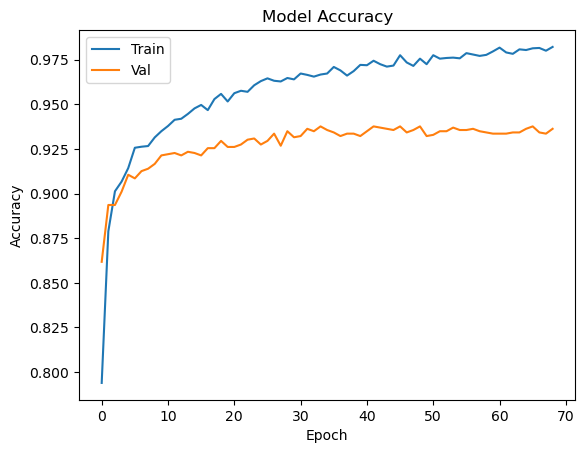

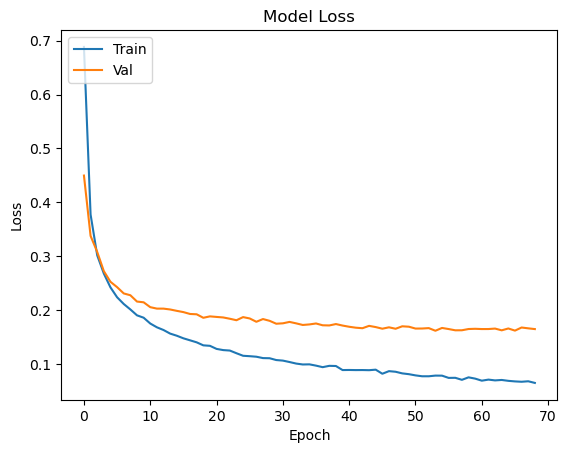

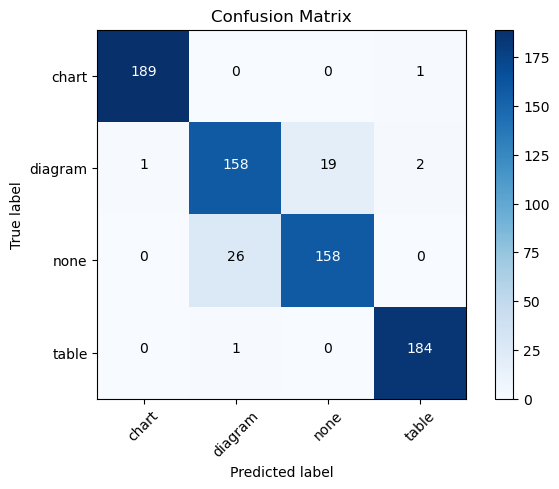

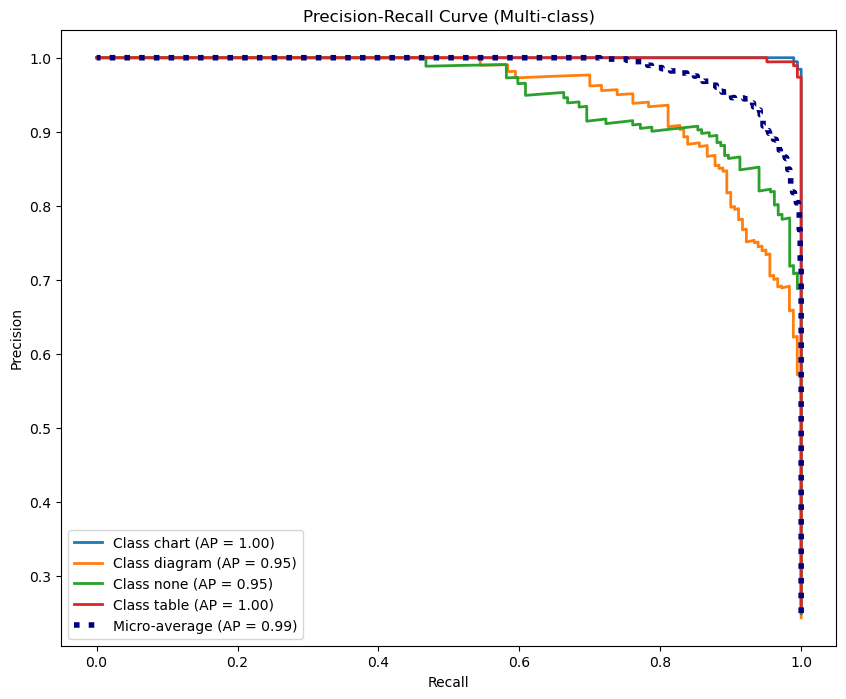

In [18]:
# Plotting Data
# Accuracy plot
fig = plt.figure()
plt.plot(history['train_accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Loss plot
fig = plt.figure()
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Confusion matrix plot
fig = plt.figure()
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

### Test Matrixs
print("Accuracy :",accuracy_score(test_labels,predictions))

plot_precision_recall_curve_multiclass(test_labels, probs, class_names)
plt.show()

In [19]:
transform_test_img = transforms.Compose([
    ResizeWithPadding(size=(244,244)),
    transforms.ToTensor()
    # test 시에는 normalize를 하지 않는다.
])
image1 = Image.open('./test1.png')
image2 = Image.open('./test2.png')
image3 = Image.open('./test3.png')
image4 = Image.open('./test4.png')
image5 = Image.open('./test5.png')
image1 = transform_test_img(image1)
image2 = transform_test_img(image2)
image3 = transform_test_img(image3)
image4 = transform_test_img(image4)
image5 = transform_test_img(image5)
plot_images_org(image1)
plot_images_org(image2)
plot_images_org(image3)
plot_images_org(image4)
plot_images_org(image5)

NameError: name 'plot_images_org' is not defined

In [ ]:
# Test for new images
vgg19_model.eval() # 추론 시에는 eval() 모드로
r1 = vgg19_model(image1.view(1,3,244,244).to(device))
r2 = vgg19_model(image2.view(1,3,244,244).to(device))
r3 = vgg19_model(image3.view(1,3,244,244).to(device))
r4 = vgg19_model(image4.view(1,3,244,244).to(device))
r5 = vgg19_model(image5.view(1,3,244,244).to(device))

In [33]:
def softmax(a):
	c = np.max(a)
	exp_a = np.exp(a - c)
	sum_exp_a = np.sum(exp_a)
	y = exp_a / sum_exp_a
	return y

In [34]:
r1_ = r1.cpu().detach().numpy().tolist()[0]
r2_ = r2.cpu().detach().numpy().tolist()[0]
r3_ = r3.cpu().detach().numpy().tolist()[0]
r4_ = r4.cpu().detach().numpy().tolist()[0]
r5_ = r5.cpu().detach().numpy().tolist()[0]
r1_class = r1_.index(max(r1_))
r2_class = r2_.index(max(r2_))
r3_class = r3_.index(max(r3_))
r4_class = r4_.index(max(r4_))
r5_class = r5_.index(max(r5_))
print([round(x,2) for x in softmax(r1_)])
print([round(x,2) for x in softmax(r2_)])
print([round(x,2) for x in softmax(r3_)])
print([round(x,2) for x in softmax(r4_)])
print([round(x,2) for x in softmax(r5_)])
print(class_names[r1_class], class_names[r2_class], class_names[r3_class], class_names[r4_class], class_names[r5_class])

[0.0, 1.0, 0.0, 0.0]
[0.0, 0.7, 0.3, 0.0]
[0.55, 0.36, 0.08, 0.01]
[0.0, 0.16, 0.84, 0.0]
[0.98, 0.01, 0.01, 0.0]
diagram diagram chart none chart


In [24]:
# model_state_path = '../../code/assets/VGG19_acc94_240728.pth'
# Save whole Model Weights
# torch.save(vgg19_model.state_dict(), model_state_path)

# Save only Weights of Classifier
# classifier_weights = vgg19_model.get_classifier().state_dict()
# torch.save(classifier_weights, '../../code/assets/VGG19clf_acc94_0728.pth')